In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import copy
from tqdm import tqdm

In [2]:
#================================================
# Load Data
#=================================================
raw_data_1 = pd.read_csv('./train_trendency.csv', index_col=['Province_State'])
raw_data_1 = raw_data_1.drop('Unnamed: 0', axis=1)
print(raw_data_1.columns)
#cleaned_df = raw_data_1.dropna(axis=1)
#raw_data_1 = raw_data_1.fillna(0)
#print(cleaned_df.columns)    
state_population = pd.read_csv('./State Populations.csv', index_col='State')

#raw_data_2 = pd.read_csv('./train_vaccine.csv', index_col=['location', 'date'])
#raw_data_2 = raw_data_2.drop('Unnamed: 0', axis=1)
#print(raw_data_2)
#cleaned_df_2 = raw_data_2.dropna(axis=1)
#print(cleaned_df_2.columns)

Index(['Date', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Incident_Rate',
       'Total_Test_Results', 'Case_Fatality_Ratio', 'Testing_Rate'],
      dtype='object')


In [3]:
vaccine_data = pd.read_csv('train_vaccine.csv', index_col=['location'])
vaccine_data['date'] = pd.to_datetime(vaccine_data['date'], format='%Y-%m-%d')
vaccine_data['date'] = vaccine_data['date'].apply(lambda x: x.strftime('%m-%d-%Y'))
vaccine_data = vaccine_data.set_index('date', append=True)
#print(vaccine_data)
vaccine_data = vaccine_data.drop('Unnamed: 0', axis=1)
vaccine_data.rename(columns={'location':'Province_State', 'date':'Date'})
#print(vaccine_data)
#print(raw_data_1.shape)
raw_data_1 = raw_data_1.join(vaccine_data, on=['Province_State', 'Date'])
#print(raw_data_1['people_fully_vaccinated'].isna().sum())


In [4]:
# Now I want to know which states have full recovered and active, which have some, and which have none
state_full = []
state_partial = []
state_none = []
States = list(set(raw_data_1.index.get_level_values('Province_State').values))
for state in States:
    # if we have recovered, then confirmed - death - recovered = active
    # in some cases, we have active, confirmed, death but no recovered,
    # I think in this situation, active may not be real active
    recovered = raw_data_1.loc[state, 'Recovered']
    if recovered.isna().all():
        state_none.append(state)
    elif recovered.isna().any():
        state_partial.append((state, recovered.isna().sum(), recovered.isna()))
    else:
        state_full.append(state)

threshold = 50
true_state_partial = []
for state, number, mask in state_partial:
    if number > 37:
        state_none.append(state)
    else:
        true_state_partial.append((state, number))

print(state_full)
for state, number in true_state_partial:
    print(state, number)
print(state_none)

#raw_data_1['Recovered'] = raw_data_1['Confirmed'] - raw_data_1['Deaths'] - raw_data_1['Active']


[]
South Carolina 25
Indiana 37
Pennsylvania 25
Idaho 25
Rhode Island 37
Arkansas 25
Kentucky 25
North Carolina 37
Texas 25
Louisiana 25
Iowa 25
Wyoming 25
Mississippi 25
New Jersey 37
New Mexico 25
Virginia 37
New York 37
Wisconsin 25
Michigan 25
Vermont 25
New Hampshire 25
Oklahoma 25
Maine 25
Montana 25
Ohio 25
Utah 25
Massachusetts 25
South Dakota 25
Minnesota 25
North Dakota 25
West Virginia 25
Colorado 37
Alabama 25
Kansas 37
Maryland 25
Arizona 37
Tennessee 25
Nebraska 25
['Illinois', 'Georgia', 'Florida', 'California', 'Missouri', 'Nevada', 'Washington', 'Connecticut', 'Oregon', 'Hawaii', 'Alaska', 'Delaware']


In [5]:
# First do some data cleaning, make "Deaths", "Confirmed", "Active" monotonically increase
data = raw_data_1.copy(deep=True)
for state in States:
    for col in ['Deaths', 'Confirmed', 'Recovered', 'people_fully_vaccinated']:
        values = data.loc[state, col].values
        length = values.shape[0]
        last_non_nan_value = values[0]
        for i in range(1, length):
            if not np.isnan(values[i]):
                if values[i] < last_non_nan_value:
                    values[i] = last_non_nan_value
                last_non_nan_value = values[i]
        data.loc[data.index==state,col] = values
data['Active'] = data['Confirmed'] - data['Deaths'] - data['Recovered']
    

data['Increased Deaths'] = 0
data['Increased Confirmed'] = 0
data['Increased Recovered'] = 0
for state in States:
    inc_deaths = data.loc[state, 'Deaths'].values[1:] - data.loc[state, 'Deaths'].values[:-1]
    inc_deaths = np.concatenate([[data.loc[state, 'Deaths'].values[0]], inc_deaths])
    data.loc[data.index==state, 'Increased Deaths'] = inc_deaths
    
    inc_confirmed = data.loc[state, 'Confirmed'].values[1:] - data.loc[state, 'Confirmed'].values[:-1]
    inc_confirmed = np.concatenate([[data.loc[state, 'Confirmed'].values[0]], inc_confirmed])
    data.loc[data.index==state, 'Increased Confirmed'] = inc_confirmed
    
    inc_recovered = data.loc[state, 'Recovered'].values[1:] - data.loc[state, 'Recovered'].values[:-1]
    inc_recovered = np.concatenate([[data.loc[state, 'Recovered'].values[0]], inc_recovered])
    data.loc[data.index==state, 'Increased Recovered'] = inc_recovered
 
print('finished inserting new columns')


    
    

finished inserting new columns


In [6]:
# Process States with weekly updated recovered data
target_states = ['Mississippi', 'Michigan', 'Alabama', 'Louisiana', 'Massachusetts', 'North Carolina']
for state in target_states:
    #print(data.loc[state, 'Recovered'])
    inc = data.loc[state, 'Increased Recovered'].values
    i = 0
    j = 0
    while not np.isnan(inc[i]):
        if inc[i] != 0:
            if i == j:
                i += 1
                j += 1
                continue
            else:
                cnt = i - j + 1
                ave_inc = inc[i]/cnt
                for k in range(j,i+1):
                    inc[k] = ave_inc
                j = i + 1
                i += 1
                continue
        else:
            # inc[i] == 0
            i += 1
    data.loc[data.index==state, 'Increased Recovered'] = inc
    cum = np.cumsum(inc)
    data.loc[data.index==state, 'Recovered'] = cum
            

In [7]:
# Since all the states have partial data, I want to use methods in "Epidemic Model Guided Machine Learning for
# COVID-19 Forecasts in the United States" to estimate Recovered based on Deaths


class RatioByDate(nn.Module):
    def __init__(self):
        super(RatioByDate, self).__init__()
        self.linear = nn.Linear(1,1)
        torch.nn.init.uniform_(self.linear.weight,-1, 0)
        
    def forward(self, x):
        #return self.linear(x)
        return torch.exp(self.linear(x))

class RatioByDatePoly(nn.Module):
    def __init__(self, order = 3):
        super(RatioByDatePoly, self).__init__()
        self.order = order
        self.linear = nn.Linear(order+1,1, bias=False)
#        torch.nn.init.uniform_(self.linear.weight,-1, 0)
        
    def forward(self, x):
        x = x/100
        return self.linear(torch.cat([x**i for i in range(self.order+1)], dim=-1))
        
    
def train(model, x, y):
    criterion = nn.L1Loss()
    epochs = 10000
    lr = 1e-4
    #scale = torch.max(d)
    #y = d / scale
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    loss_list = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        model.train()
        #pred = (r+d+1)*model(x) / scale
        pred = model(x)
        loss = criterion(pred, y)
        reg_loss = torch.mean(torch.abs(model.linear.weight))
        loss += 1*reg_loss
        loss.backward()
        loss_list.append(loss.item())
        optimizer.step()
    #plt.plot(list(range(epochs)), loss_list)
    #print(model.linear.weight)
        #with torch.no_grad():
        #    model.linear.weight.copy_(torch.clamp(model.linear.weight, max = 0, min = math.log(min_ratio)/80))
   # print(reg_loss)
    
# estimate a, b for states having enough recoverd, death data
state_ratio_by_date = {}
plot_cnt = 4
plot_cur = 0

data['Old Recovered'] = data['Recovered']

for state, _ in tqdm(true_state_partial):
    inc_deaths = data.loc[state, 'Increased Deaths'].values
    inc_recovered = data.loc[state, 'Increased Recovered'].values
    ratios = (inc_deaths[1:] + 1) / (inc_recovered[1:] + inc_deaths[1:] + 2)
    date = np.array(list(range(1, inc_deaths.shape[0])))
    
    model = RatioByDatePoly(order = 1)
    mask = (1 - np.isnan(ratios)).astype(np.bool_)
    
    x = torch.FloatTensor(date[mask]).view(-1,1)
    #d = torch.FloatTensor(deaths[mask]).view(-1,1)
    y = torch.FloatTensor(ratios[mask]).view(-1,1)
    #r = torch.FloatTensor(recovered[mask]).view(-1,1)
    train(model, x, y)
    
    #a, b = model.linear.weight[0,0].detach().item(), model.linear.bias[0].detach().item()
    state_ratio_by_date[state] = model
 
    pred_recovered = [inc_recovered[0]]
    for t in date:
        inc_death = inc_deaths[t]
        #ratio = np.exp(a*t+b)
        ratio = model(torch.FloatTensor([t])).item()
        pred_inc_recovered = (inc_death+1) / ratio - 2 - inc_death
        if pred_inc_recovered < 0:
            pred_inc_recovered = 0
        if np.isnan(inc_recovered[t]) == False:
            recovered_t = pred_recovered[-1] + inc_recovered[t]
        else:
            recovered_t = pred_recovered[-1] + pred_inc_recovered
        pred_recovered.append(recovered_t)
    data.loc[data.index==state, 'Recovered'] = np.array(pred_recovered)
    #print(data['Recovered'].loc[state])
    #mask = np.array([False]+list(mask))
    #error = np.abs(np.array(pred_recovered)[mask] - data.loc[state, 'Recovered'].values[mask])
    #error = error / data.loc[state, 'Recovered'].values[mask]
    #print(state)
    #print(np.mean(error))
    if False:
        #pass
        #print(state)
        #print(inc_deaths)
        #print(inc_recovered)
        #print(data.loc[state, 'Deaths'])
        #print(ratio)
        #print(y.squeeze())
        #pred = model(x).squeeze()
        #print(pred)
        #print(model.linear.weight)
        #print(a, b)
        date = np.array(list(range(0, inc_deaths.shape[0])))
        plt.figure()
        #plt.plot(x,y,c='blue')
        #plt.plot(x,pred.detach(),c='red')
        plt.plot(date, data.loc[state, 'Recovered'].values, c='blue')
        plt.plot(date, np.array(pred_recovered), c='green')
        plt.show()
        plot_cur += 1
            
data['Active'] = data['Confirmed'] - data['Deaths'] - data['Recovered']
print('Finish')
"""

for state, _ in tqdm(true_state_partial):
    if state != 'Maine':
        continue
    deaths = data.loc[state, 'Deaths'].values
    recovered = data.loc[state, 'Recovered'].values
    ratios = deaths / (deaths + recovered + 1)
    date = np.array(range(deaths.shape[0]))
    
    model = RatioByDatePoly(order = 1)
    mask = ((1 - np.isnan(ratios)) * (ratios != 0)).astype(np.bool_)
    
    x = torch.FloatTensor(date[mask]).view(-1,1)
    d = torch.FloatTensor(deaths[mask]).view(-1,1)
    #y = torch.FloatTensor(ratios[mask]).view(-1,1)
    r = torch.FloatTensor(recovered[mask]).view(-1,1)
    min_ratio = torch.min(y).item()/5
    train(model, x, r, d, min_ratio)
    
    #a, b = model.linear.weight[0,0].detach().item(), model.linear.bias[0].detach().item()
    state_ratio_by_date[state] = model
 
    pred_recovered = np.zeros_like(recovered)
    error = np.zeros_like(mask).astype(np.float64)
    preds = []
    for t in date:
        ratio = model(torch.FloatTensor([t])).item()
        pred = (deaths[t] / ratio) - 1 - deaths[t]
        if np.isnan(recovered[t]):
            pred_recovered[t] = max(pred, pred_recovered[t-1])
            #print(pred_recovered[t-1:t+1])
        else:
            pred_recovered[t] = recovered[t]
            error[t] = np.abs(pred - recovered[t])
            print(pred, recovered[t])
            preds.append(pred)
    plt.plot(range(len(preds)), preds, c='red')
    plt.plot(range(len(preds)), recovered[:len(preds)], c='blue')
    mask = np.array(list(mask))
    
    #print(np.mean(error))
    if False:
        date = np.array(list(range(0, inc_deaths.shape[0])))
        plt.figure()
        plt.plot(date, data.loc[state, 'Recovered'].values, c='blue')
        plt.plot(date, np.array(pred_recovered), c='green')
        plt.show()
        plot_cur += 1

data['Active'] = data['Confirmed'] - data['Deaths'] - data['Recovered']
"""
# set entries where active < 0 to 0, and recmopute recovered 
data.loc[data['Active']<0, 'Active'] = 0
data['Recovered'] = data['Confirmed'] - data['Deaths'] - data['Active']
print('Finish')

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [02:40<00:00,  4.47s/it]


Finish
Finish


In [8]:
# define ODE model
def SuEIRD(t, y, N, beta, sigma, mu, gamma, alpha, eta):
    # y[0] is S, y[1] is E, y[2] is I, y[3] is R(recovered), y[4] is D (deaths)
    gradient = np.zeros_like(y)
    gradient[0] = - beta * (y[2] + y[1]) * y[0] / N
    gradient[1] = beta * (y[2] + y[1]) * y[0] / N - sigma * y[1]
    gradient[2] =  mu * sigma * y[1] - gamma * y[2]
    gradient[3] = gamma * np.exp(-eta - alpha*y[2]/N) * y[2]
    gradient[4] = gamma * (1-np.exp(-eta - alpha*y[2]/N)) * y[2]
    return gradient


def SuEIRD_old(t, y, N, beta, sigma, mu, gamma, alpha):
    # y[0] is S, y[1] is E, y[2] is I, y[3] is R(recovered), y[4] is D (deaths)
    gradient = np.zeros_like(y)
    gradient[0] = - beta * (y[2] + y[1]) * y[0] / N
    gradient[1] = beta * (y[2] + y[1]) * y[0] / N - sigma * y[1]
    gradient[2] =  mu * sigma * y[1] - gamma * y[2]
    gradient[3] = gamma * alpha * y[2]
    gradient[4] = gamma * (1-alpha) * y[2]
    return gradient

def predict_with_ODE(fun, t_span, y0, t_eval, args):
    sol = solve_ivp(lambda t,y: fun(t,y,*args), t_span, y0, t_eval = t_eval, method='RK45')
    return sol.y

# not used
def optimize_SuEIRD_parameters(beta0, sigma0, mu0, gamma0, alpha0, N0, I, R, D, t_span, y0, t_eval):
    I_max = np.max(I)
    R_max = np.max(R)
    D_max = np.max(D)
    scale_I = I / I_max
    scale_R = R / R_max
    scale_D = D / D_max
   
    def loss(x):
        y = predict_with_ODE(SuEIRD, t_span, y0, t_eval, args = (N0, x[0], x[1], x[2], x[3], x[4]))
        #print(y)
        I_pred = y[2,:] / I_max
        R_pred = y[3,:] / R_max
        D_pred = y[4,:] / D_max
        res = np.array(np.concatenate([I_pred-scale_I, R_pred - scale_R, D_pred - scale_D])).astype(np.float64)
        return np.abs(res)
    x0 = np.array([beta0, sigma0, mu0, gamma0, alpha0])
    return least_squares(loss, x0, bounds = (0, 1))

# used optimization function
def optimize_SuEIRD_parameters_CD(beta0, sigma0, mu0, gamma0, alpha0, eta0, N0, I, R, C, D, t_span, y0, t_eval, mask):
    
    C_max = np.max(C)
    D_max = np.max(D)
    scale_C = C / C_max
    scale_D = D / D_max
    
    if I is not None:
        I_max = np.max(I[mask])
        R_max = np.max(R[mask])
        scale_R = R[mask] / R_max
        scale_I = I[mask] / I_max
        #print(scale_I)
        #print(scale_R)
    
    def loss(x):
        y = predict_with_ODE(SuEIRD, t_span, y0, t_eval, args = (N0, x[0], x[1], x[2], x[3], x[4], x[5]))
        #print(y)
        C_pred = (y[2,:]+y[3,:]+y[4,:])/C_max
        D_pred = y[4,:] / D_max
        if I is not None:
            I_pred = y[2,mask] / I_max
            R_pred = y[3,mask] / R_max
            res = np.array(np.concatenate([C_pred-scale_C, D_pred - scale_D, 
                                       0.3*(R_pred-scale_R), 0.3*(I_pred-scale_I)])).astype(np.float64)
        else:
            res = np.array(np.concatenate([C_pred-scale_C, D_pred - scale_D])).astype(np.float64)
        return np.abs(res)
    x0 = np.array([beta0, sigma0, mu0, gamma0, alpha0, eta0])
    return least_squares(loss, x0, bounds = (0, [1,1,1,1, np.inf, np.inf]), jac='3-point')

# not used
def optimize_SuEIRD_parameters_CD_old(beta0, sigma0, mu0, gamma0, alpha0, N0, I, R, C, D, t_span, y0, t_eval, mask):
    
    C_max = np.max(C)
    D_max = np.max(D)
    scale_C = C / C_max
    scale_D = D / D_max
    
    if I is not None:
        I_max = np.max(I[mask])
        R_max = np.max(R[mask])
        scale_R = R[mask] / R_max
        scale_I = I[mask] / I_max
        #print(scale_I)
        #print(scale_R)
    
    def loss(x):
        y = predict_with_ODE(SuEIRD, t_span, y0, t_eval, args = (N0, x[0], x[1], x[2], x[3], x[4]))
        #print(y)
        C_pred = (y[2,:]+y[3,:]+y[4,:])/C_max
        D_pred = y[4,:] / D_max
        if I is not None:
            I_pred = y[2,mask] / I_max
            R_pred = y[3,mask] / R_max
            res = np.array(np.concatenate([C_pred-scale_C, D_pred - scale_D, 
                                       0.3*(R_pred-scale_R), 0.3*(I_pred-scale_I)])).astype(np.float64)
        else:
            res = np.array(np.concatenate([C_pred-scale_C, D_pred - scale_D])).astype(np.float64)
        return np.abs(res)
    x0 = np.array([beta0, sigma0, mu0, gamma0, alpha0, eta0, pi0])
    return least_squares(loss, x0, bounds = (0, 1), jac='3-point')

In [9]:
# training states with partial recovered and active data

N0_ratio_list = [0.7, 0.8, 0.9, 1]
E0_ratio_list = [0.1, 0.2, 0.3, 0.4, 0.5]


best_ratio = {}
state_params = {}
best_mape_list = []
valid_cnt = 28
for state, _ in tqdm(true_state_partial):
    best_mape = 10
    for N0_ratio in N0_ratio_list:
        for E0_ratio in E0_ratio_list:
            # split training and validation set
            values = data.loc[state].values
            training_data = values[:-valid_cnt,:]
            valid_data = values[-valid_cnt:,:]
    
            # set y0
            I0 = values[0,4] # Active
            R0 = values[0,3] # Recovered
            D0 = values[0,2]
            N0 = N0_ratio * state_population.loc[state].values[0]
            E0 = E0_ratio * state_population.loc[state].values[0]
            S0 = N0 - E0 - I0 - R0 - D0
            if S0 < 0 and N0_ratio_list == 1:
                print(state)
                print('Warning E0: %.3f'%(E0_ratio))
            y0 = np.array([S0, E0, I0, R0, D0])
    
            # set initial values for parameters
            x0 = np.random.rand(6)
    
            # set t_span, t_eval
            t_span = (0, training_data.shape[0]-1)
            t_eval = np.array(list(range(training_data.shape[0]))).astype(np.float64)
    
            # retrieve I, R
            I = training_data[:,4]
            R = training_data[:,3]
            C = training_data[:,1]
            D = training_data[:,2]
            mask = ~data.loc[state, 'Old Recovered'].isna()
            mask = mask[:-valid_cnt]
            #mask = [True for i in range(I.shape[0])]
            #date = np.array(range(values.shape[0])).astype(np.float64)
            #ratios = state_ratio_by_date[state](torch.FloatTensor(date).view(-1,1))
            #ratios = ratios.detach().numpy().squeeze()
            
    
            res = optimize_SuEIRD_parameters_CD(x0[0], x0[1], x0[2], x0[3], x0[4], x0[5], N0, I, R, C, D, t_span, y0, t_eval, mask)
    
            # predict with learned parameters and compute MAPE on validation dataset
            pred = predict_with_ODE(SuEIRD, (0, values.shape[0]), y0, t_eval = np.array(range(values.shape[0])).astype(np.float64), 
                                   args = (N0, res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5]))
            pred_valid = pred[2,-valid_cnt:] + pred[3,-valid_cnt:] + pred[4,-valid_cnt:]
            pred_death_ = pred[4,-valid_cnt:]
            death_valid = valid_data[:,2]
            
            mape = np.mean(np.abs(valid_data[:,1]-pred_valid) / valid_data[:,1]) +\
                            np.mean(np.abs(pred_death_-death_valid)/death_valid)
            
            if mape < best_mape:
                best_mape = mape    
                best_ratio[state] = (N0_ratio, E0_ratio)
                state_params[state] = copy.deepcopy(res)
    # use best ratio to retrain model with whole training data
    N0_ratio, E0_ratio = best_ratio[state][0], best_ratio[state][1]
    I0 = values[0,4] # Active
    R0 = values[0,3] # Recovered
    D0 = values[0,2]
    N0 = N0_ratio * state_population.loc[state].values[0]
    E0 = E0_ratio * state_population.loc[state].values[0]
    S0 = N0 - E0 - I0 - R0 - D0
    y0 = np.array([S0, E0, I0, R0, D0])
    x0 = state_params[state].x
    I = values[:,4]
    R = values[:,3]
    C = values[:,1]
    D = values[:,2]
    mask = ~data.loc[state, 'Old Recovered'].isna()
    t_span = (0, values.shape[0]-1)
    t_eval = np.array(range(values.shape[0])).astype(np.float64)
    res = optimize_SuEIRD_parameters_CD(x0[0], x0[1], x0[2], x0[3], x0[4], x0[5], N0, I, R, C, D, t_span, y0, t_eval, mask)
    best_mape_list.append(best_mape) 
    print(state, best_ratio[state], best_mape)
print(np.mean(best_mape_list))

  0%|                                                                                           | 0/38 [00:00<?, ?it/s]

South Carolina (0.9, 0.2) 0.1196259652932733


  3%|██▏                                                                                | 1/38 [00:37<23:25, 37.99s/it]

Indiana (0.8, 0.1) 0.06039941238270579


  5%|████▎                                                                              | 2/38 [01:10<21:44, 36.23s/it]

Pennsylvania (0.8, 0.4) 0.0361739386120855


  8%|██████▌                                                                            | 3/38 [01:29<18:11, 31.17s/it]

Idaho (1, 0.1) 0.03850440359912291


 11%|████████▋                                                                          | 4/38 [02:05<18:31, 32.70s/it]

Rhode Island (0.8, 0.1) 0.08150366390538547


 13%|██████████▉                                                                        | 5/38 [02:24<15:36, 28.39s/it]

Arkansas (0.7, 0.5) 0.019167160466097698


 16%|█████████████                                                                      | 6/38 [02:52<15:13, 28.54s/it]

Kentucky (0.9, 0.2) 0.04000100201238581


 18%|███████████████▎                                                                   | 7/38 [03:18<14:14, 27.57s/it]

North Carolina (0.7, 0.5) 0.014115035109649888


 21%|█████████████████▍                                                                 | 8/38 [03:32<11:48, 23.61s/it]

Texas (0.9, 0.5) 0.03927183447361235


 24%|███████████████████▋                                                               | 9/38 [03:48<10:16, 21.25s/it]

Louisiana (0.7, 0.5) 0.035343459405580965


 26%|█████████████████████▌                                                            | 10/38 [04:15<10:47, 23.13s/it]

Iowa (0.8, 0.3) 0.024404822523721028


 29%|███████████████████████▋                                                          | 11/38 [04:34<09:45, 21.67s/it]

Wyoming (1, 0.2) 0.007978008237602485


 32%|█████████████████████████▉                                                        | 12/38 [04:55<09:17, 21.44s/it]

Mississippi (1, 0.2) 0.044235662264682014


 34%|████████████████████████████                                                      | 13/38 [05:18<09:13, 22.16s/it]

New Jersey (1, 0.1) 0.06072895661807962


 37%|██████████████████████████████▏                                                   | 14/38 [06:05<11:44, 29.34s/it]

New Mexico (0.8, 0.4) 0.029993109119990063


 39%|████████████████████████████████▎                                                 | 15/38 [06:23<10:02, 26.19s/it]

Virginia (1, 0.3) 0.05953099679328899


 42%|██████████████████████████████████▌                                               | 16/38 [06:47<09:16, 25.30s/it]

New York (1, 0.1) 0.06448333243809021


 45%|████████████████████████████████████▋                                             | 17/38 [07:30<10:45, 30.73s/it]

Wisconsin (1, 0.1) 0.04485512122035259


 47%|██████████████████████████████████████▊                                           | 18/38 [08:01<10:16, 30.81s/it]

Michigan (0.9, 0.1) 0.02665654891050193


 50%|█████████████████████████████████████████                                         | 19/38 [09:28<15:04, 47.62s/it]

Vermont (1, 0.1) 0.07912256484706903


 53%|███████████████████████████████████████████▏                                      | 20/38 [10:34<15:57, 53.22s/it]

New Hampshire (0.9, 0.3) 0.03290745829980416


 55%|█████████████████████████████████████████████▎                                    | 21/38 [11:08<13:28, 47.54s/it]

Oklahoma (1, 0.1) 0.04925867861028491


 58%|███████████████████████████████████████████████▍                                  | 22/38 [11:40<11:22, 42.68s/it]

Maine (1, 0.1) 0.20604298733537657


 61%|█████████████████████████████████████████████████▋                                | 23/38 [12:21<10:34, 42.28s/it]

Montana (1, 0.4) 0.02217870213563597


 63%|███████████████████████████████████████████████████▊                              | 24/38 [13:23<11:14, 48.21s/it]

Ohio (0.9, 0.2) 0.0259825299663443


 66%|█████████████████████████████████████████████████████▉                            | 25/38 [14:30<11:40, 53.90s/it]

Utah (1, 0.1) 0.06617644142966303


 68%|████████████████████████████████████████████████████████                          | 26/38 [15:19<10:29, 52.46s/it]

Massachusetts (1, 0.1) 0.022982096155496963


 71%|██████████████████████████████████████████████████████████▎                       | 27/38 [16:27<10:27, 57.03s/it]

South Dakota (0.8, 0.3) 0.015006715861738166


 74%|████████████████████████████████████████████████████████████▍                     | 28/38 [17:18<09:11, 55.16s/it]

Minnesota (0.8, 0.1) 0.03322209944824772


 76%|██████████████████████████████████████████████████████████████▌                   | 29/38 [18:37<09:22, 62.49s/it]

North Dakota (1, 0.5) 0.00694757447708156


 79%|████████████████████████████████████████████████████████████████▋                 | 30/38 [20:13<09:39, 72.50s/it]

West Virginia (1, 0.3) 0.09449678466950366


 82%|██████████████████████████████████████████████████████████████████▉               | 31/38 [20:54<07:21, 63.05s/it]

Colorado (1, 0.1) 0.06076671207257014


 84%|█████████████████████████████████████████████████████████████████████             | 32/38 [21:44<05:54, 59.09s/it]

Alabama (1, 0.1) 0.12807332429803453


 87%|███████████████████████████████████████████████████████████████████████▏          | 33/38 [22:33<04:40, 56.12s/it]

Kansas (1, 0.4) 0.1188932803667943


 89%|█████████████████████████████████████████████████████████████████████████▎        | 34/38 [23:37<03:53, 58.34s/it]

Maryland (1, 0.1) 0.08600945602941226


 92%|███████████████████████████████████████████████████████████████████████████▌      | 35/38 [24:53<03:10, 63.66s/it]

Arizona (1, 0.1) 0.14137768398273404


 95%|█████████████████████████████████████████████████████████████████████████████▋    | 36/38 [25:35<01:54, 57.19s/it]

Tennessee (0.7, 0.5) 0.01193449850365158


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 37/38 [26:08<00:49, 49.93s/it]

Nebraska (0.8, 0.5) 0.01689483048968993


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [26:50<00:00, 47.64s/it]


0.054348601378035294


In [16]:
# predict
pred_cfm = {}
pred_death = {}
for state, _ in true_state_partial:
    #print(state)
    # split training and validation set
    values = data.loc[state].values
    training_data = values[:,:]
#    valid_data = values[-7:,:]
    N0_ratio, E0_ratio = best_ratio[state]
    # set y0
    I0 = values[0,4] # Active
    R0 = values[0,3] # Recovered + Death
    D0 = values[0,2]
    N0 = N0_ratio * state_population.loc[state].values[0]
    E0 = E0_ratio * state_population.loc[state].values[0]
    S0 = N0 - E0 - I0 - R0 - D0
    y0 = np.array([S0, E0, I0, R0, D0])
    
    # set initial values for parameters
    #x0 = np.random.rand(4)
    
    # set t_span, t_eval
    t_span = (0, values.shape[0]+30)
    t_eval = np.array(range(values.shape[0]+30)).astype(np.float64)
    res = state_params[state]
    pred = predict_with_ODE(SuEIRD, t_span, y0, t_eval = t_eval, 
                           args = (N0, res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5]))
    
    
    new_S0, new_E0 = pred[0, values.shape[0]-1], pred[1, values.shape[0]-1]
    new_R0 = pred[3, values.shape[0]-1]
    new_I0 = values[78,1] - new_R0 - values[78, 2]
    
    t_span = (0, 31)
    t_eval = np.array(range(31)).astype(np.float64)
    
    y0 = np.array([new_S0, new_E0, new_I0, new_R0, values[78,2]])
    #err = N0 - np.sum(y0)
    #y0[]
    #y0[1] += err/2
    pred = predict_with_ODE(SuEIRD, t_span, y0, t_eval = t_eval, 
                           args = (N0, res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5]))
    pred_cfm[state] = pred[2,1:31] + pred[3,1:31] + pred[4,1:31]
    #print(death.shape)
    #break
    pred_death[state] = pred[4,1:31]
    
    #pred_cfm[state] = pred[2,-30:] + pred[3,-30:] + pred[4,-30:]
    #pred_death[state] = pred[4,-30:]
print('Finish')

Finish


In [18]:
best_ratio_value = np.array(list(best_ratio.values()))
N0_E0_ratio = np.mean(best_ratio_value, axis=0)
#print(N0_E0_ratio)
N0_ratio, E0_ratio = N0_E0_ratio[0], N0_E0_ratio[1]
print(N0_ratio, E0_ratio)

0.9105263157894737 0.24473684210526303


In [ ]:
# Now process states without any recovered data
a_list = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
b_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

def predictRatio(t, a, b):
    t = t/100
    return a * t + b

train_date = 51
valid_date = 79
total_date = 109

for state in tqdm(state_none):
    # Try to predict Recovered Data
    best_params = None
    best_mape = 100
    death = data.loc[state, 'Deaths'].values
    confirmed = data.loc[state, 'Confirmed'].values
    for a in a_list:
        for b in b_list:
            t = np.array(range(0, total_date)).astype(np.float64)
            ratio = predictRatio(t, a, b)
            if np.sum(ratio <= 0) > 0:
                continue
            #print(ratio)
            removed = death / ratio[:valid_date] - 1
            active =  confirmed - removed
            
            I0 = active[0]
            R0 = removed[0] - death[0]
            D0 = death[0]
            N0 = N0_ratio * state_population.loc[state].values[0]
            E0 = E0_ratio * state_population.loc[state].values[0]
            S0 = N0 - E0 - I0 - R0 - D0
            y0 = np.array([S0, E0, I0, R0, D0])
            #print(ratio)
            #print(y0)
            #print(N0)
            x0 = np.random.rand(6)
            
            t_span = (0, train_date)
            t_eval = np.array(range(0, train_date)).astype(np.float64)
            
            I = active[:train_date]
            R = removed[:train_date] - death[:train_date]
            C = confirmed[:train_date]
            D = death[:train_date]
            
            #print(I)
            #print(R)
            
            res = optimize_SuEIRD_parameters_CD(x0[0], x0[1], x0[2], x0[3], x0[4], x0[5], 
                                                N0, None, None, C, D, t_span, y0, t_eval, None)
            
            pred = predict_with_ODE(SuEIRD, (0, valid_date), y0, t_eval = np.array(range(valid_date)).astype(np.float64), 
                           args = (N0, res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5]))
            pred_valid = pred[2,train_date:] + pred[3,train_date:] + pred[4,train_date:]
            valid_data = data.loc[state, 'Confirmed'].values[train_date:]
            
            pred_death_ = pred[4,train_date:]
            valid_death = death[train_date:]
            mape = np.mean(np.abs(valid_data-pred_valid) / valid_data) + np.mean(np.abs(valid_death-pred_death_)/valid_death)
            if mape < best_mape:
                best_mape = mape
                best_params = (a, b, N0, res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5])
    print(state, best_mape)
    ratio = predictRatio(0, best_params[0], best_params[1])
    R0 = death[0]/ratio - 1 - death[0]
    D0 = death[0]
    I0 = confirmed[0] - R0 - D0
    N0 = N0_ratio * state_population.loc[state].values[0]
    E0 = E0_ratio * state_population.loc[state].values[0]
    S0 = N0 - E0 - I0 - R0 - D0
    y0 = np.array([S0, E0, I0, R0, D0])
    
    C = confirmed[:valid_date]
    D = death[:valid_date]
    
    # retrain model with whole training data
    x0 = best_params[-6:]
    t_span = (0, valid_date)
    t_eval = np.array(range(0, valid_date)).astype(np.float64)
    res = optimize_SuEIRD_parameters_CD(x0[0], x0[1], x0[2], x0[3], x0[4], x0[5], N0, None, None, C, D, t_span, y0, t_eval, None)
    
    # use best parameters to predict
    best_params = (best_params[0], best_params[1], N0, res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5])
    state_params[state] = best_params
    pred = predict_with_ODE(SuEIRD, (0, total_date), y0, t_eval = np.array(range(total_date)).astype(np.float64), 
                            args = best_params[-7:])
    
    #new_S0, new_E0 = pred[0, valid_date-1], pred[1, valid_date-1]
    #t_span = (0, total_date - valid_date)
    #t_eval = np.array(range(31)).astype(np.float64)
    #ratio = predictRatio(valid_date-1, best_params[0], best_params[1])
    #new_R0 = death[valid_date-1]/ratio - 1 - death[valid_date-1]
    
    # retrieve I, R
    #I = training_data[:,4]
    #R = training_data[:,2] + training_data[:,3]
    
    #res = optimize_SuEIR_parameters(x0[0], x0[1], x0[2], x0[3], N0, I, R, t_span, y0, t_eval)
    #state_params[state] = res.x
    #y0 = np.array([new_S0, new_E0, confirmed[valid_date-1]-new_R0-death[valid_date-1], new_R0, death[valid_date-1]])
    #err = N0 - np.sum(y0)
    #y0[0] += err/2
    #y0[1] += err/2
    #pred = predict_with_ODE(SuEIRD, t_span, y0, t_eval = t_eval, 
                           #args = (N0, res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5]))
    #pred_cfm[state] = pred[2,1:31] + pred[3,1:31] + pred[4,1:31]
    #pred_death[state] = pred[4,1:31]
    
    pred_cfm[state] = pred[2,-30:] + pred[3,-30:] + pred[4,-30:]
    pred_death[state] = pred[4,-30:]

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

In [17]:
# Write submission.csv
test_data = pd.read_csv('test.csv')
test_data['Date'] = pd.to_datetime(test_data['Date'], format='%m-%d-%Y')
start_date = pd.to_datetime('04-01-2021', format='%m-%d-%Y')
for index in test_data.index:
    idx = (test_data.loc[index, 'Date'] - start_date).days
    state = test_data.loc[index, 'Province_State']
   
    test_data.loc[index, 'Confirmed'] = pred_cfm[state][idx]
    test_data.loc[index, 'Deaths'] = pred_death[state][idx]

test_data.loc[:,['Confirmed', 'Deaths']].to_csv('submission.csv')

Province_State
Oklahoma    2804
Oklahoma    2848
Oklahoma    2882
Oklahoma    2925
Oklahoma    2952
Oklahoma    2987
Oklahoma    2994
Oklahoma    3037
Oklahoma    3085
Oklahoma    3140
Oklahoma    3187
Oklahoma    3231
Oklahoma    3279
Oklahoma    3293
Oklahoma    3323
Oklahoma    3388
Oklahoma    3423
Oklahoma    3471
Oklahoma    3504
Oklahoma    3547
Oklahoma    3564
Oklahoma    3602
Oklahoma    3654
Oklahoma    3681
Oklahoma    3710
Oklahoma    3761
Oklahoma    3813
Oklahoma    3817
Oklahoma    3870
Oklahoma    3900
            ... 
Oklahoma    4534
Oklahoma    4534
Oklahoma    4534
Oklahoma    4534
Oklahoma    4534
Oklahoma    4534
Oklahoma    4534
Oklahoma    4701
Oklahoma    4701
Oklahoma    4701
Oklahoma    4701
Oklahoma    4701
Oklahoma    4701
Oklahoma    4701
Oklahoma    4788
Oklahoma    4788
Oklahoma    4788
Oklahoma    4788
Oklahoma    4788
Oklahoma    4788
Oklahoma    4788
Oklahoma    4788
Oklahoma    4850
Oklahoma    4850
Oklahoma    4850
Oklahoma    4850
Oklahoma    4850

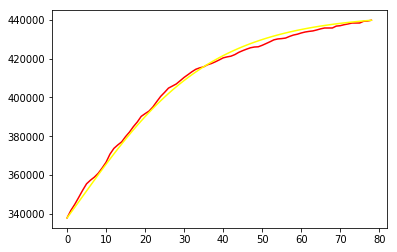

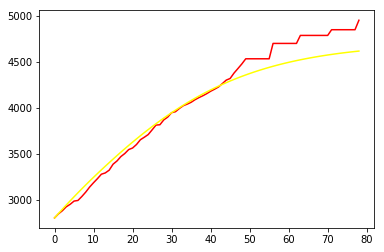

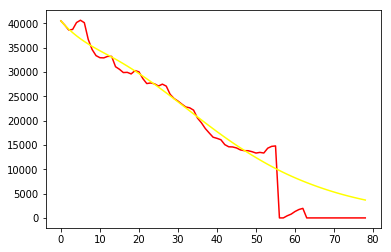

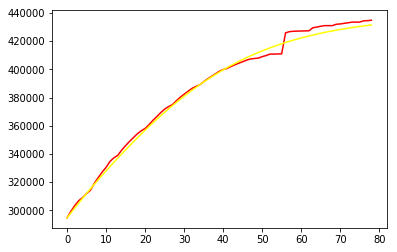

In [14]:
# For debugging
target_state = 'Oklahoma'
for state, _ in true_state_partial:
    if state != target_state:
        continue
    N0_ratio, E0_ratio = best_ratio[state]
    values = data.loc[state].values
    # set y0
    I0 = values[0,4] # Active
    R0 = values[0,3] # Recovered
    D0 = values[0,2]
    N0 = N0_ratio * state_population.loc[state].values[0]
    E0 = E0_ratio * state_population.loc[state].values[0]
    S0 = N0 - E0 - I0 - R0 - D0
    y0 = np.array([S0, E0, I0, R0, D0])
    
    # set initial values for parameters
    #x0 = np.random.rand(4)
    
    # set t_span, t_eval
    t_span = (0, values.shape[0]+1)
    t_eval = np.array(range(values.shape[0])).astype(np.float64)
    res = state_params[state]
    pred = predict_with_ODE(SuEIRD, t_span, y0, t_eval = t_eval, 
                           args = (N0, res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5]))
    
    date = np.array(range(79))
    death = pred[4,:] 
    plt.figure()
    #print(values[:,1])
    #print(pred[2,:]+pred[3,:]+pred[4,:])
    plt.plot(date, values[:,1], c='red') # confirmed
    plt.plot(date, pred[2,:]+pred[3,:]+pred[4,:], c='yellow')
    plt.figure()
    plt.plot(date, values[:,2], c='red') # death
    plt.plot(date, death, c='yellow')
    
    plt.figure()
    plt.plot(date, values[:,4], c='red') #active
    plt.plot(date, pred[2,:], c='yellow')
    
    plt.figure()
    plt.plot(date, values[:,3], c='red') #recovered
    plt.plot(date, pred[3,:], c='yellow')
    
    
    
    print(data.loc[state, 'Deaths'])
print('Finish')